In [3]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"
!pip install parse
!pip install torchfile

Cloning into 'deepflows'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 1940 (delta 69), reused 59 (delta 32), pack-reused 1824
Receiving objects: 100% (1940/1940), 58.05 MiB | 28.58 MiB/s, done.
Resolving deltas: 100% (1237/1237), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp37-none-any.whl size=23795 sha256=dbbb02e1088269d8c66db9af83502c3cbd792414fa04b2174e742c7b02d1d4d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-zcxowx6k/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc
  Found existing installation: recurrent-flows-msc 0.1.0
    Uninstalling recurrent-flows-msc-0.1.0:
      Successfully uninstalled recurrent-flows-msc-0.1.0
  Created wheel for parse: filename=parse-1.19.0-cp37-none-any.whl size=24581 sha256=5629b60ec838f26eb5718c20678db07ca2ea2eeafc3189c

In [5]:
from deepflows.data_generators import celeba
from deepflows.Utils import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from deepflows.data_generators import stochasticShapes
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import torch.distributions as td
from deepflows.Utils.utils import *
from deepflows.data_generators import stochasticMovingMnist
import matplotlib.patches as patches
device = utils.set_gpu(True)

# Load Conditional Data

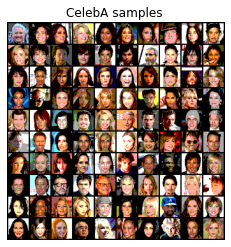

In [ ]:
train_data, test_data = celeba.get_celeba(plot_sample=True)

'''
Function transforming CelebA data to conditioned CelebA dataset
'''
def get_joint_conditioned_data(data, box_size = (8, 24)):
  i, j = box_size
  x = data.copy()
  y = data.copy()
  h, w=data.shape[-2:]

  # Set the inner square to 0
  x[:, :, i:j, i:j] = 0
  
  # Set the outer square to 0
  get_ids = np.concatenate((np.arange(0, i, 1),np.arange(j, w, 1)))
  y[:, :, get_ids, :] = 0
  y[:, :, :, get_ids] = 0

  return np.concatenate((x, y), axis=1)

trainset = get_joint_conditioned_data(train_data)
testset = get_joint_conditioned_data(test_data)

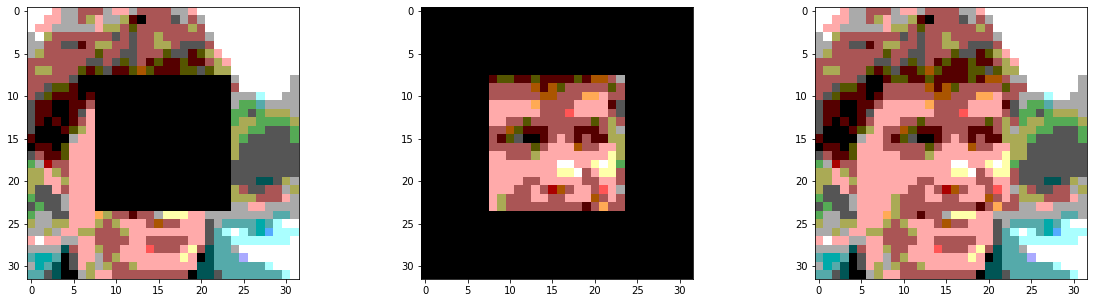

In [ ]:
x, y = torch.tensor(trainset).split(3, 1)
x = x[8].permute(1, 2, 0)
y = y[8].permute(1, 2, 0)
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow(x/x.max())
ax[1].imshow(y/y.max())
ax[2].imshow((y+x)/(y+x).max())
plt.show()

# Unconditional/Simple Conditional Glow

In [6]:
class ActNorm(nn.Module):

    def __init__(self, num_channels):
        super().__init__()

        size = [1, num_channels, 1, 1]
        self.register_parameter("bias", nn.Parameter(torch.zeros(*size), requires_grad=True))
        self.register_parameter("logs", nn.Parameter(torch.zeros(*size), requires_grad=True))
        
        # Buffer to register if initialization has been performed
        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))

    def initialize(self, input):
      if not self.training:
        return

      with torch.no_grad():
          bias = input.clone().mean(dim=[0, 2, 3], keepdim=True)
          std_input = input.clone().std(dim=[0, 2, 3], keepdim=True)
          logs = (1.0 / (std_input + 1e-6)).log()
          self.bias.data.copy_(-bias)
          self.logs.data.copy_(logs)

    def forward(self, input, logdet, reverse):
        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        dims = input.size(2) * input.size(3)

        if reverse == False:
            input = input + self.bias
            input = input * self.logs.exp()
            dlogdet = torch.sum(self.logs) * dims
            if logdet is not None:
              logdet = logdet + dlogdet

        if reverse == True:
            input = input * self.logs.mul(-1).exp()
            input = input - self.bias
            dlogdet = - torch.sum(self.logs) * dims
            if logdet is not None:
              logdet = logdet + dlogdet

        return input, logdet

class Conv2dZeros(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=[3,3], stride=[1,1]):
        super().__init__()
        
        padding = (kernel_size[0] - 1) // 2
        self.conv = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride, padding=padding)
        
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()

    def forward(self, input):
      output = self.conv(input)
      return output 

class Conv2dNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=[3, 3], stride=[1, 1], norm = "actnorm"):
        super().__init__()

        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=(norm != "actnorm"))
        self.conv.weight.data.normal_(mean=0.0, std=0.05)
        
        self.norm = norm
        if self.norm == "actnorm":
          self.norm_type = ActNorm(out_channels)
        elif self.norm=="batchnorm":
          self.conv.bias.data.zero_()
          self.norm_type = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        output = self.conv(input)
        if self.norm == "actnorm":
          output,_ = self.norm_type(output, logdet=0.0, reverse=False)
        elif self.norm == "batchnorm":
          output = self.norm_type(output)
        else:
          return output
        return output

class Conv2dResize(nn.Module):
    def __init__(self, in_size, out_size, kernel_size = [3,3], stride = 2, norm="actnorm", manual = False):
        super().__init__()
        #condition size = in size
        if not manual:
          stride = [in_size[1]//out_size[1], in_size[2]//out_size[2]]
          kernel_size = Conv2dResize.compute_kernel_size(in_size, out_size, stride)
        else:
          stride = stride
          kernel_size = kernel_size
        if norm == None:
          self.conv = nn.Conv2d(in_channels=in_size[0], out_channels=out_size[0], kernel_size=kernel_size, stride=stride, bias = True)
          self.conv.bias.data.zero_()
        else:
          self.conv = nn.Conv2d(in_channels=in_size[0], out_channels=out_size[0], kernel_size=kernel_size, stride=stride, bias = False)
        self.conv.weight.data.zero_()
        
        self.norm = norm
        if self.norm == "actnorm":
          self.norm_type = ActNorm(out_size[0])
        elif self.norm=="batchnorm":
          self.norm_type = nn.BatchNorm2d(out_size[0])

    @staticmethod
    def compute_kernel_size(in_size, out_size, stride):
        k0 = in_size[1] - (out_size[1] - 1) * stride[0]
        k1 = in_size[2] - (out_size[2] - 1) * stride[1]
        return[k0, k1]

    def forward(self, input):
      output = self.conv(input)
      if self.norm == "actnorm":
        output,_ = self.norm_type(output, logdet=0.0, reverse=False)
      elif self.norm == "batchnorm":
        output = self.norm_type(output)
      return output 

non_lin = "relu"

class ActFun(nn.Module):
  def __init__(self, non_lin, in_place = False):
    super(ActFun, self).__init__()
    if non_lin=='relu':
      self.net=nn.ReLU(inplace = in_place)
    if non_lin=='leakyrelu':
      self.net=nn.LeakyReLU(negative_slope=0.20, inplace = in_place)

  def forward(self,x):
    return self.net(x)

class InvConv(nn.Module):
    def __init__(self, num_channels, LU_decomposed):
        super().__init__()
        w_shape = [num_channels, num_channels]
        w_init = torch.qr(torch.randn(*w_shape))[0]

        if not LU_decomposed:
            self.weight = nn.Parameter(torch.Tensor(w_init))
        else:
            p, lower, upper = torch.lu_unpack(*torch.lu(w_init))
            s = torch.diag(upper)
            sign_s = torch.sign(s)
            log_s = torch.log(torch.abs(s))
            upper = torch.triu(upper, 1)
            l_mask = torch.tril(torch.ones(w_shape), -1)
            eye = torch.eye(*w_shape)

            self.register_buffer("p", p)
            self.register_buffer("sign_s", sign_s)
            self.lower = nn.Parameter(lower)
            self.log_s = nn.Parameter(log_s)
            self.upper = nn.Parameter(upper)
            self.l_mask = l_mask
            self.eye = eye

        self.w_shape = w_shape
        self.LU_decomposed = LU_decomposed

    def get_weight(self, input, reverse):
        b, c, h, w = input.shape

        if not self.LU_decomposed:
            dlogdet = torch.slogdet(self.weight)[1] * h * w
            if reverse:
                weight = torch.inverse(self.weight)
            else:
                weight = self.weight
        else:
            self.l_mask = self.l_mask.to(input.device)
            self.eye = self.eye.to(input.device)

            lower = self.lower * self.l_mask + self.eye

            u = self.upper * self.l_mask.transpose(0, 1).contiguous()
            u = u + torch.diag(self.sign_s * torch.exp(self.log_s))

            dlogdet = torch.sum(self.log_s) * h * w

            if reverse:
                u_inv = torch.inverse(u)
                l_inv = torch.inverse(lower)
                p_inv = torch.inverse(self.p)

                weight = torch.matmul(u_inv, torch.matmul(l_inv, p_inv))
            else:
                weight = torch.matmul(self.p, torch.matmul(lower, u))

        return weight.view(self.w_shape[0], self.w_shape[1], 1, 1), dlogdet

    def forward(self, input, logdet, reverse):
        weight, dlogdet = self.get_weight(input, reverse)

        if not reverse:
            z = F.conv2d(input, weight)
            if logdet is not None:
              logdet = logdet + dlogdet
            return z, logdet
        else:
            z = F.conv2d(input, weight)
            if logdet is not None:
              logdet = logdet - dlogdet
            return z, logdet

class AffineCoupling(nn.Module):
    def __init__(self, x_size, condition_size):
        super(AffineCoupling, self).__init__()
        
        Bx, Cx, Hx, Wx = x_size
        if condition_size is not None:
          B, C, H, W = condition_size
          temp = torch.zeros(condition_size)
          temp = temp.view(Bx, -1, Hx, Wx)
          channels = Cx // 2 + temp.shape[1]
        else:
          channels = Cx // 2

        hidden_channels = 128
        self.net = nn.Sequential(
            Conv2dNorm(channels, hidden_channels),
            ActFun(non_lin),
            Conv2dNorm(hidden_channels, hidden_channels, kernel_size=[1, 1]),
            ActFun(non_lin),
            Conv2dZeros(hidden_channels, Cx),
        )

        self.scale = nn.Parameter(torch.zeros(Cx//2, 1, 1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(Cx//2, 1, 1), requires_grad=True)
        
    def forward(self, x, condition, logdet, reverse): # how to match condition here for L>1
        z1, z2 = utils.split_feature(x, "split")

        if condition is not None:
          condition = condition.view(x.shape[0], -1, x.shape[2], x.shape[3])
          assert condition.shape[2:4] == x.shape[2:4], "condition and x in affine needs to match"
          h = torch.cat([z1, condition], dim=1)
        else:
          h = z1
        
        shift, log_scale = utils.split_feature(self.net(h), "cross")
        # Here we could try to use the exponential as suggested in arXiv:1907.02392v3
        log_scale = self.scale * torch.tanh(log_scale) + self.scale_shift

        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * torch.exp(log_scale)
            if logdet is not None:
              logdet = logdet + torch.sum(log_scale, dim=[1, 2, 3])
        else:
            z2 = z2 * log_scale.mul(-1).exp()
            z2 = z2 - shift
            if logdet is not None:
              logdet = logdet - torch.sum(log_scale, dim=[1, 2, 3]) 

        output = torch.cat((z1, z2), dim=1)
        return output, logdet


class GlowStep(nn.Module):
    def __init__(self, x_size, condition_size, LU_decompose):
      super(GlowStep, self).__init__()
      
      b, c, h, w = x_size
      if condition_size is not None:
        bc, cc, hc, wc = condition_size
      self.actnorm = ActNorm(c)
      self.invconv =  InvConv(c, LU_decomposed = LU_decompose)
      self.affine =  AffineCoupling(x_size, condition_size)
       
    def forward(self, x, condition, logdet, reverse):
        if reverse == False:
            x, logdet = self.actnorm(x, logdet, reverse=False)
            x, logdet = self.invconv(x, logdet, reverse=False)
            x, logdet = self.affine(x, condition, logdet, reverse=False)
            return x, logdet
        else:
            x, logdet = self.affine(x, condition, logdet, reverse=True)
            x, logdet = self.invconv(x, logdet, reverse=True)
            x, logdet = self.actnorm(x, logdet, reverse=True)
            return x, logdet


class Squeeze2d(nn.Module):
    def __init__(self):
        super(Squeeze2d, self).__init__()
        
    def forward(self, x, undo_squeeze):
      B, C, H, W = x.shape
      if undo_squeeze == False:
        # C x H x W -> 4C x H/2 x W/2
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
      else:
        # 4C x H/2 x W/2  ->  C x H x W
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
      return x


class Split2d(nn.Module):
    def __init__(self, x_size, condition_size):
      super(Split2d, self).__init__()

      Bx, Cx, Hx, Wx = x_size
      if condition_size is not None: # We should be able to remove temp when list of conds is implemented
        B, C, H, W = condition_size
        temp = torch.zeros(condition_size)
        temp = temp.view(Bx, -1, Hx, Wx)
        channels = Cx // 2 + temp.shape[1]
      else:
        channels = Cx // 2
        
      self.conv = nn.Sequential(Conv2dZeros(channels, Cx),)
      

    def forward(self, x, condition, logdet, reverse):
        if condition is not None:
          condition = condition.view(x.shape[0], -1, x.shape[2], x.shape[3])
          
        if reverse == False:
            z1, z2 = utils.split_feature(x, "split")
            if condition is not None:
              h = torch.cat([z1, condition], dim=1)
            else:
              h = z1
            out = self.conv(h)
            mean, log_scale = utils.split_feature(out, "cross")
            if logdet is not None:
              logdet = logdet + torch.sum(td.Normal(mean, torch.exp(log_scale)).log_prob(z2), dim=(1,2,3))
            return z1, logdet
        else:
            if condition is not None:
              h = torch.cat([x, condition], dim=1)
            else:
              h = x
            mean, log_scale = utils.split_feature(self.conv(h), "cross")
            z2 = td.Normal(mean, torch.exp(log_scale)).rsample()
            z = torch.cat((x, z2), dim=1)
            return z, logdet

class Glow(nn.Module):
    def __init__(self, x_size, condition_size = None, K = 12, L = 2, learn_prior = True, LU_decompose = True):
        super(Glow, self).__init__()

        self.L = L
        self.K = K
        Bx, Cx, Hx, Wx = x_size
        if condition_size is not None:
          Bc, Cc, Hc, Wc = condition_size
        layers = []

        for l in range(0, L):
            layers.append(Squeeze2d())
            Cx, Hx, Wx = Cx * 4, Hx // 2, Wx // 2
            x_size =  [Bx, Cx, Hx, Wx]
            for i in range(0, K):
                layers.append(GlowStep(x_size, condition_size, LU_decompose))
            
            if l < (L-1):
                layers.append(Split2d(x_size, condition_size)) 
                Cx = Cx // 2 
                x_size = [Bx, Cx, Hx, Wx]

        self.glow_frame = nn.ModuleList(layers)

        self.learn_prior = learn_prior
        if learn_prior == True:
          if condition_size is not None:
            self.prior = nn.Sequential(
                Conv2dResize((Cc, Hc, Wc), out_size=(64, Hx*2, Wx*2), norm=None),
                ActFun(non_lin),
                Conv2dResize((64, Hx*2, Wx*2), out_size=(32, Hx, Wx), norm=None),
                ActFun(non_lin),
                Conv2dZeros(in_channel=32, out_channel=2*Cx)
                )
          else:
            self.prior_in = torch.zeros([1, Cx, Hx, Wx,]).to(device)
            self.prior = Conv2dZeros(in_channel=Cx, out_channel=2*Cx)
        else:
          self.prior_in = torch.zeros([1, 2*Cx, Hx, Wx,]).to(device)
          

    def g(self, z, condition, logdet):
        # maps z -> x
        x = z
        for step in reversed(self.glow_frame):
          if isinstance(step, Squeeze2d):
            x = step(x, undo_squeeze=True)
          elif isinstance(step, Split2d):
            x, logdet = step(x, condition, logdet = logdet, reverse=True)
          else:
            x, logdet = step(x, condition, logdet = logdet, reverse=True)
        return x, logdet

    def f(self, x, condition, logdet):
        # maps x -> z
        z = x
        for step in self.glow_frame:
            if isinstance(step, Squeeze2d):
                z = step(z, undo_squeeze=False)
            elif isinstance(step, Split2d):
                z, logdet = step(z, condition, logdet = logdet, reverse=False)
            else:
                z, logdet = step(z, condition, logdet=logdet, reverse=False)
        return z, logdet
    
    def log_prob(self, x, condition=None, logdet = None):
        dims = torch.prod(torch.tensor(x.shape[1:]))
        z, obj = self.f(x, condition, logdet)
        
        if condition is not None:
          z_in = condition
        else:
          z_in = self.prior_in.repeat(x.shape[0],1,1,1)

        if self.learn_prior:
          mean, log_scale = utils.split_feature(self.prior(z_in), type="split")
        else:
          mean, log_scale = utils.split_feature(self.prior_in.repeat(x.shape[0],1,1,1), type="split")
          
        prior = td.Normal(mean, torch.exp(log_scale))
        obj = obj + torch.sum(prior.log_prob(z), dim=(1,2,3)) #p_z
        obj = torch.mean(obj)
        nll = (-obj) / float(np.log(2.) * dims)
        return z, nll

    def sample(self, z, condition=None, num_samples = 32, temperature=0.8):
    
        with torch.no_grad():
          if z == None:

            if condition is not None:
              z_in = condition
            else:
              z_in = self.prior_in.repeat(num_samples,1,1,1)

            if self.learn_prior:
              mean, log_scale = utils.split_feature(self.prior(z_in), type="split")
            else:
              mean, log_scale = utils.split_feature(self.prior_in.repeat(num_samples,1,1,1), type="split")

            prior = td.Normal(mean, torch.exp(log_scale)*temperature)
            z = prior.sample().to(device)
          x, _ = self.g(z, condition, logdet=None)
        return x
    

# Conditional Glow Celeba 2-bit

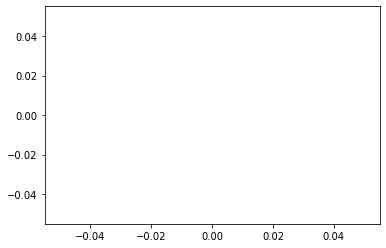

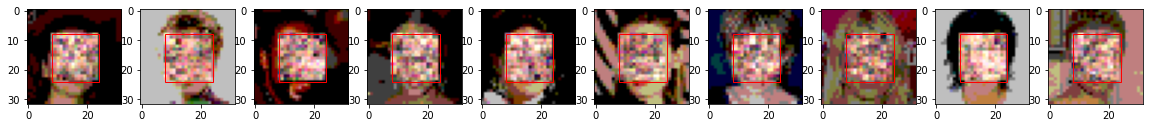

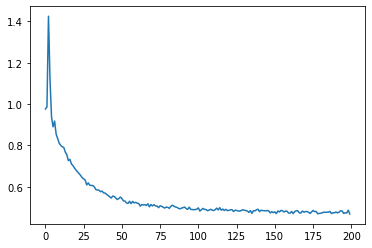

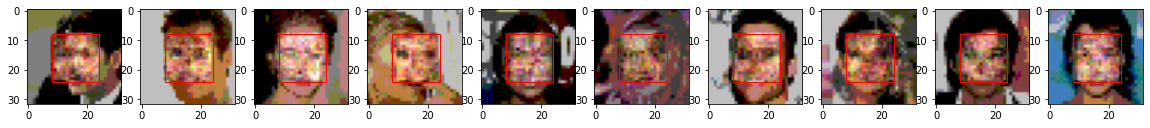

Epoch 1 Loss: 0.52


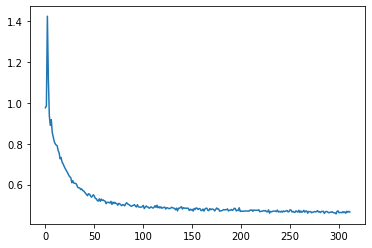

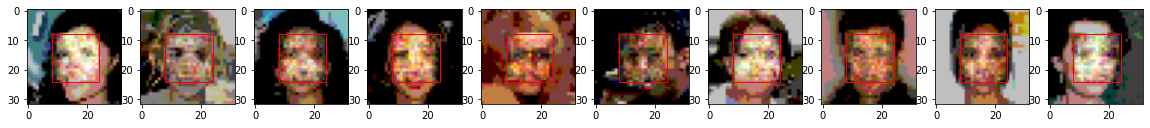

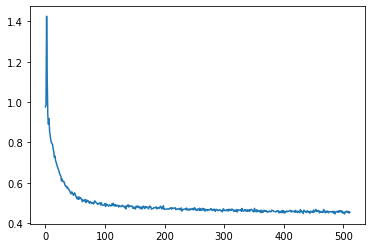

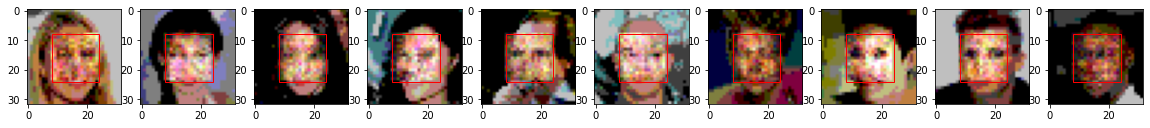

Epoch 2 Loss: 0.46


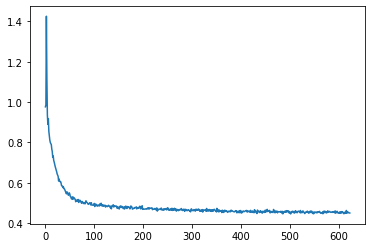

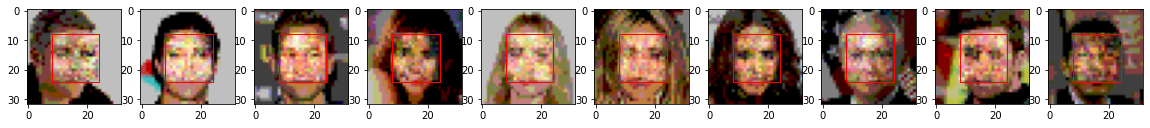

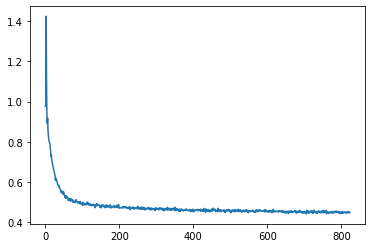

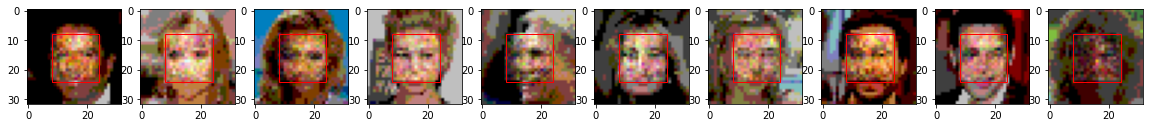

Epoch 3 Loss: 0.45


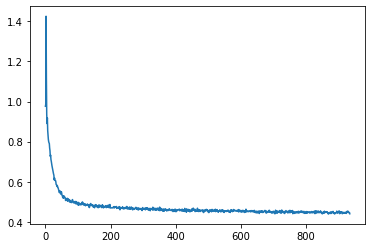

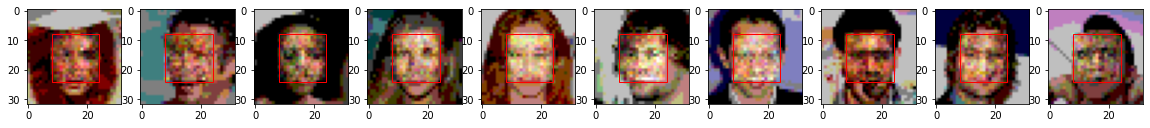

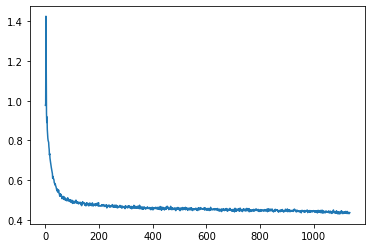

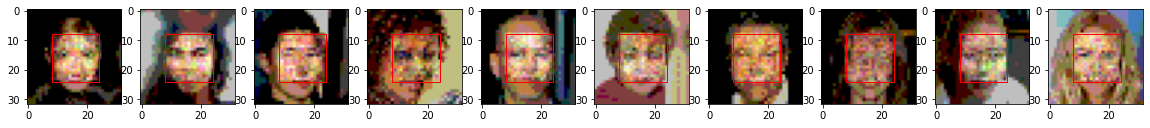

Epoch 4 Loss: 0.44


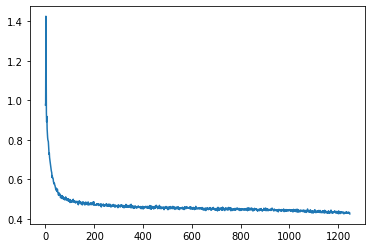

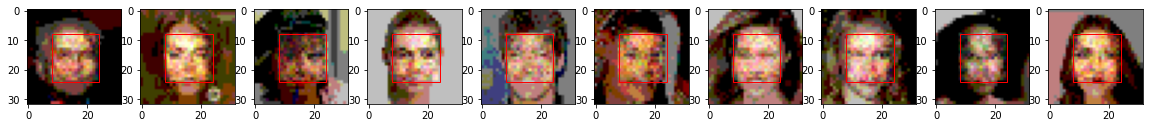

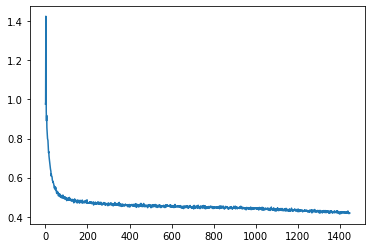

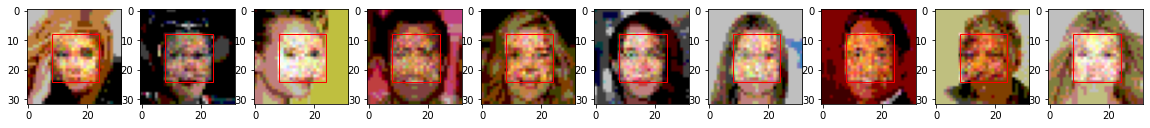

Epoch 5 Loss: 0.42


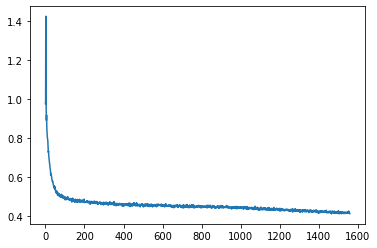

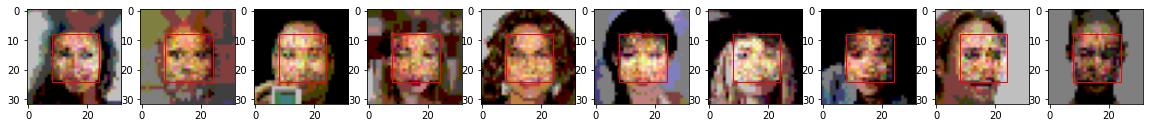

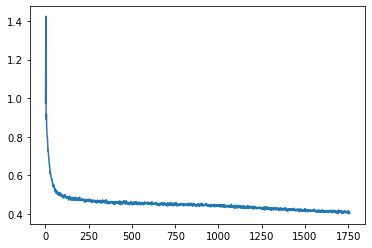

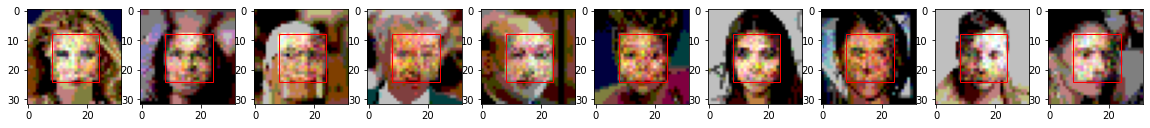

Epoch 6 Loss: 0.41


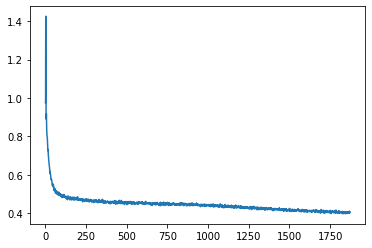

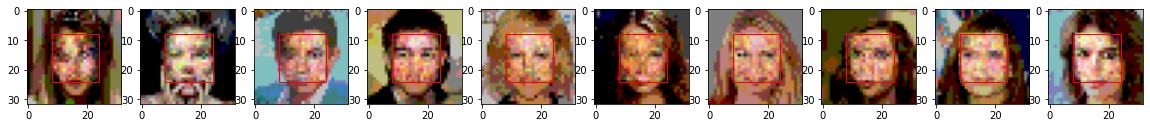

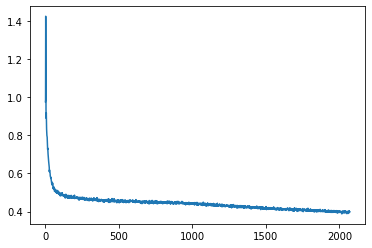

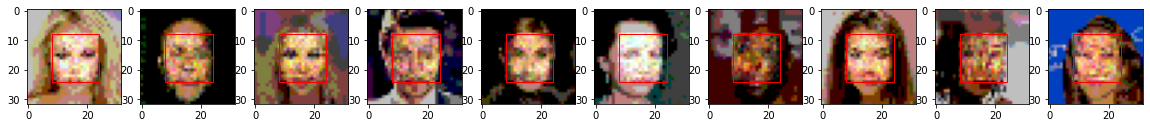

Epoch 7 Loss: 0.40


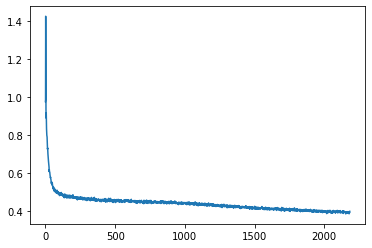

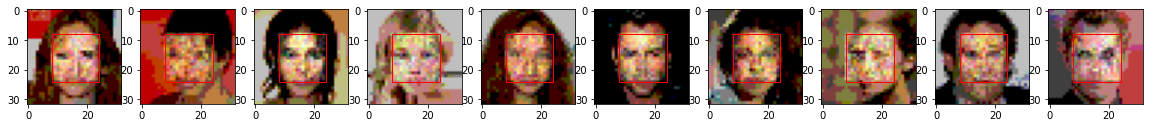

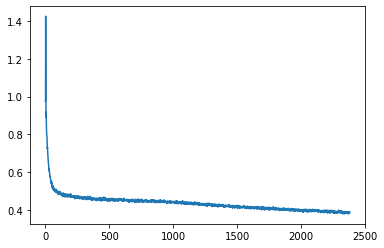

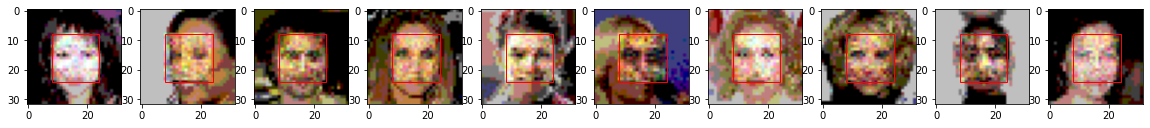

Epoch 8 Loss: 0.39


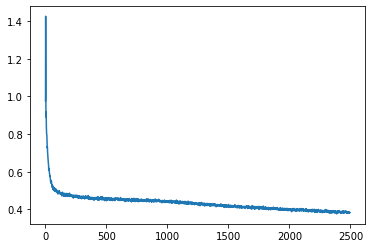

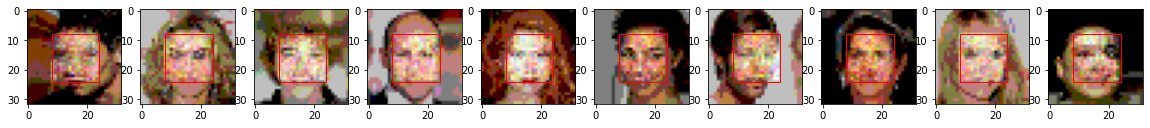

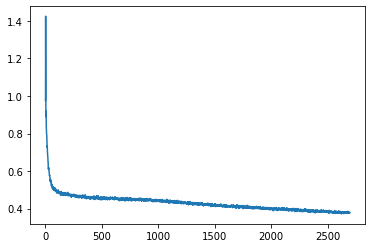

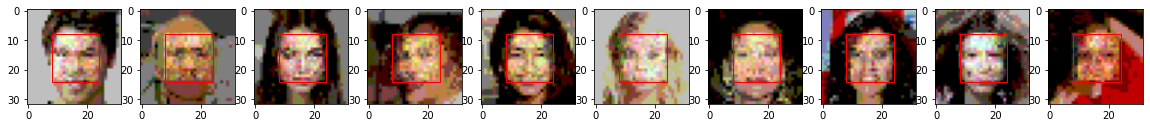

Epoch 9 Loss: 0.38


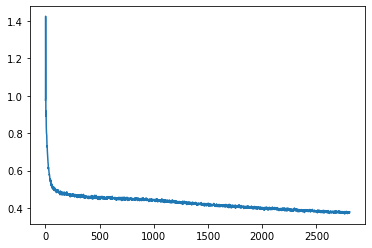

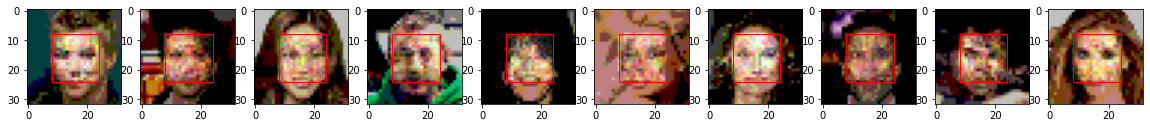

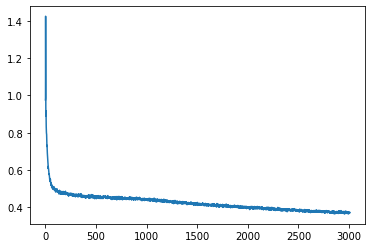

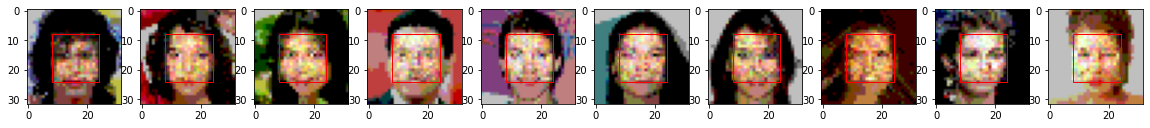

Epoch 10 Loss: 0.37


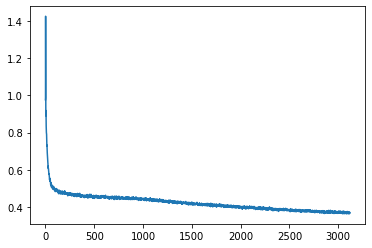

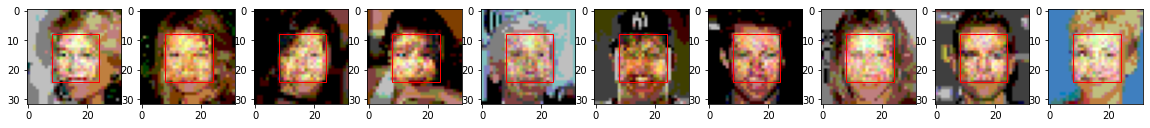

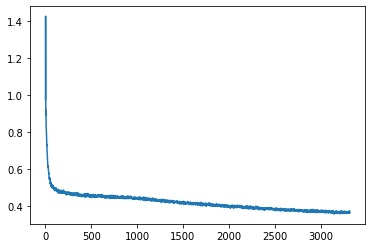

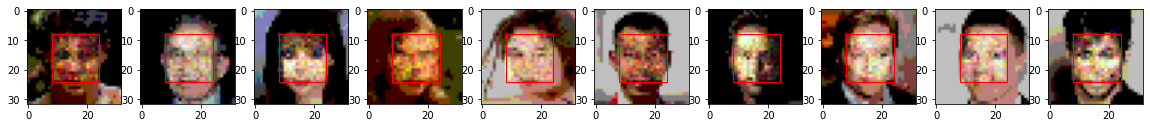

Epoch 11 Loss: 0.37


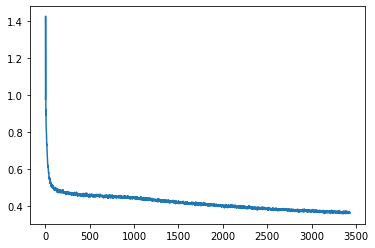

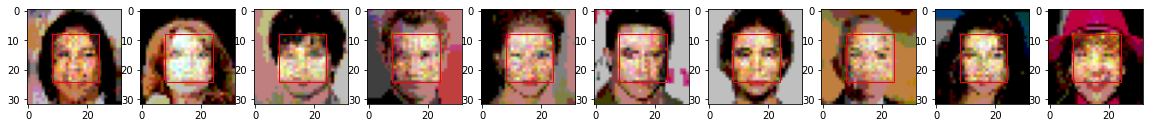

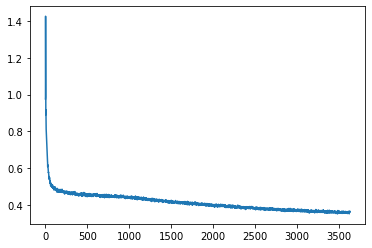

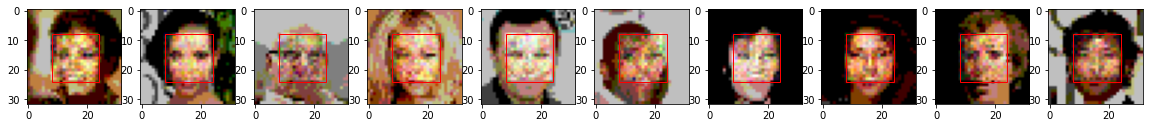

Epoch 12 Loss: 0.36


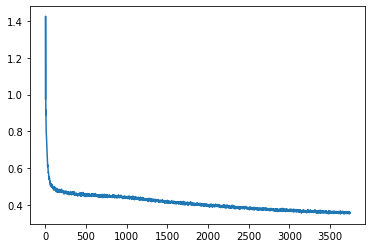

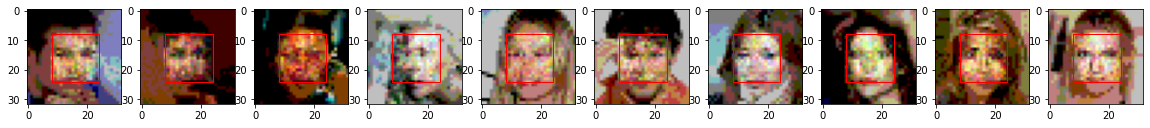

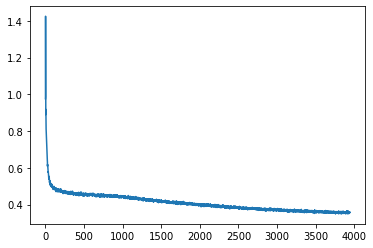

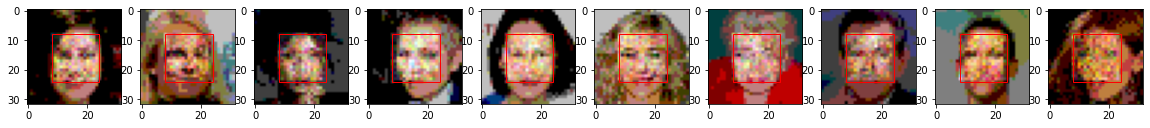

Epoch 13 Loss: 0.36


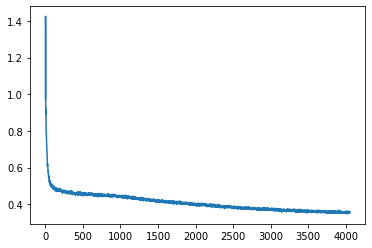

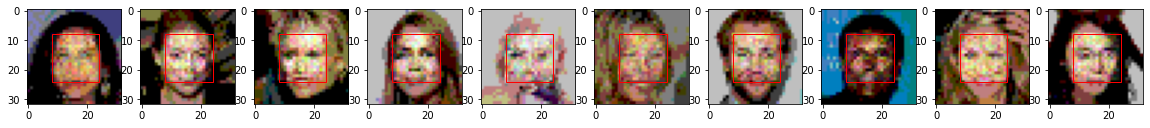

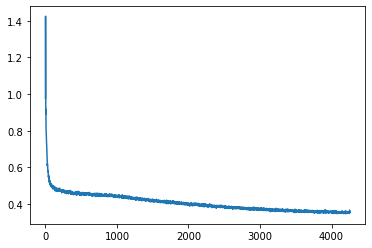

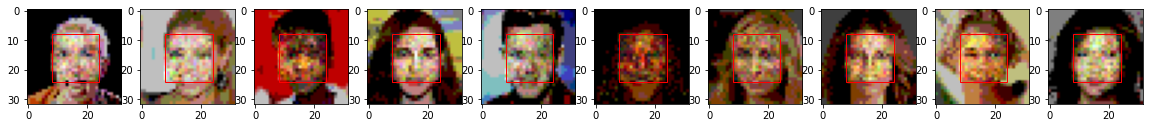

Epoch 14 Loss: 0.35


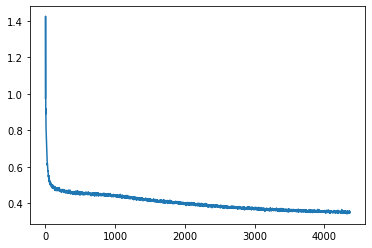

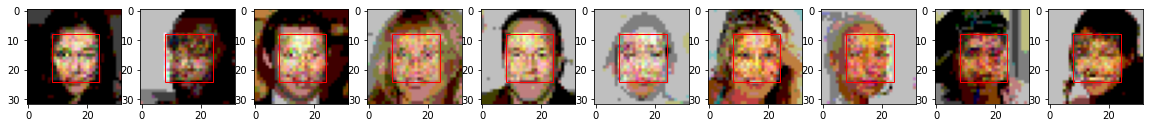

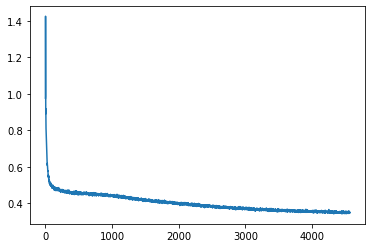

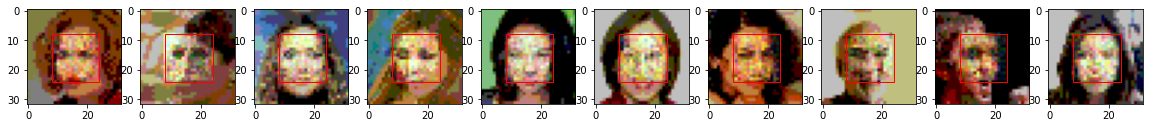

Epoch 15 Loss: 0.35


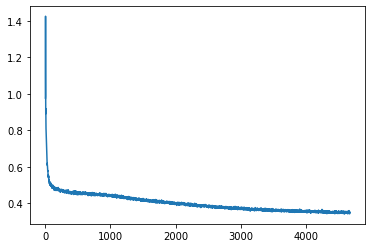

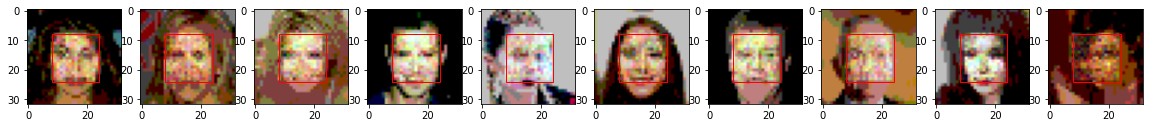

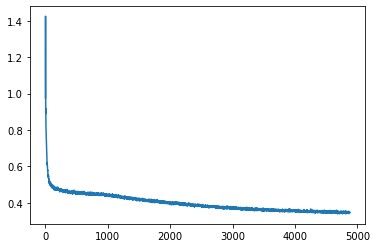

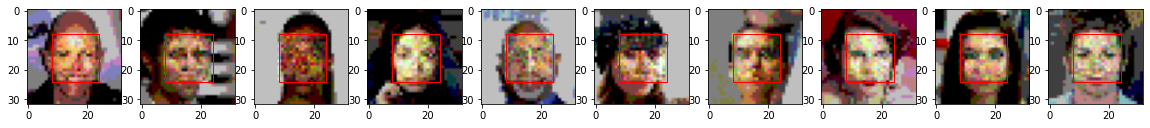

Epoch 16 Loss: 0.35


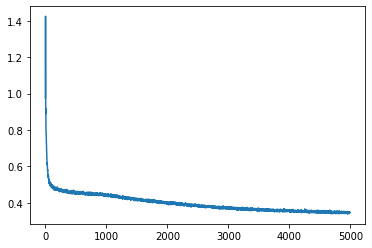

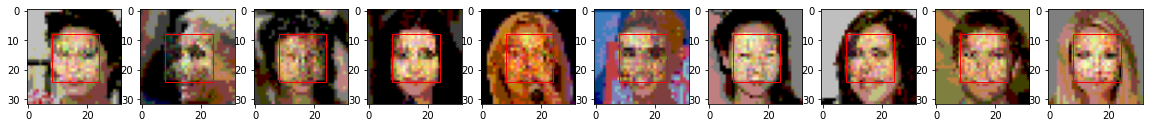

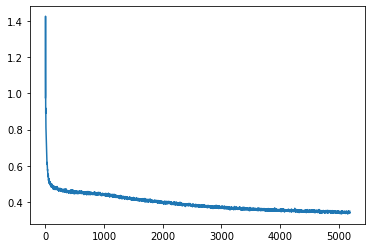

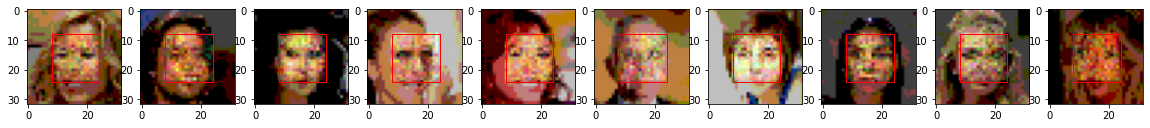

Epoch 17 Loss: 0.34


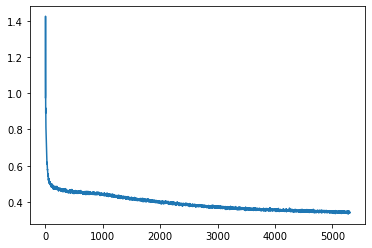

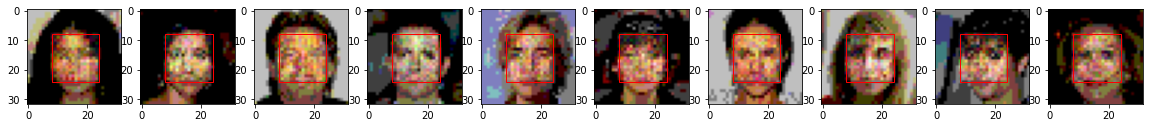

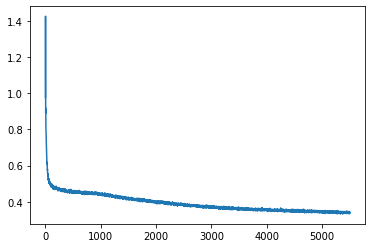

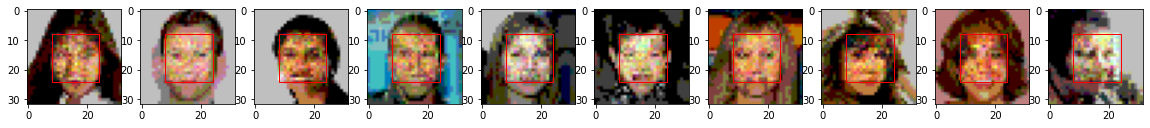

Epoch 18 Loss: 0.34


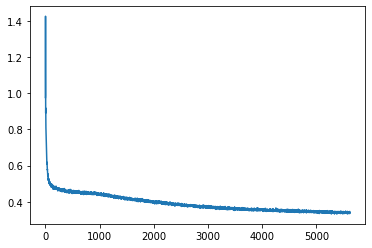

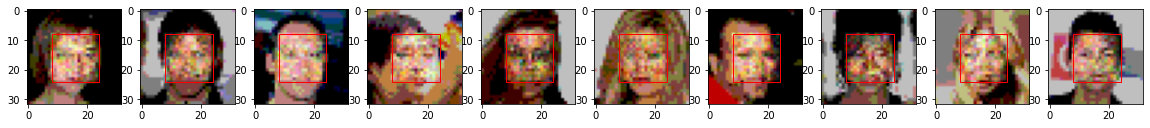

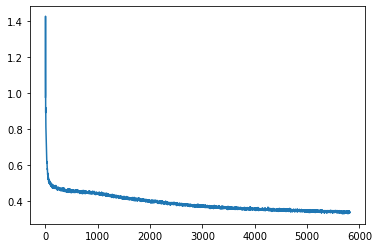

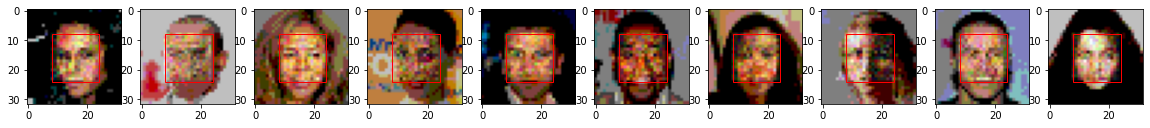

Epoch 19 Loss: 0.34


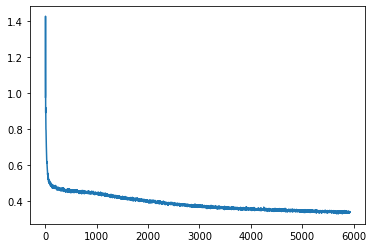

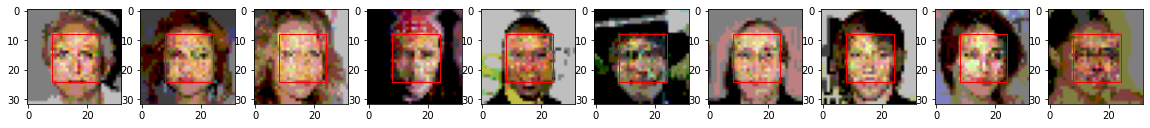

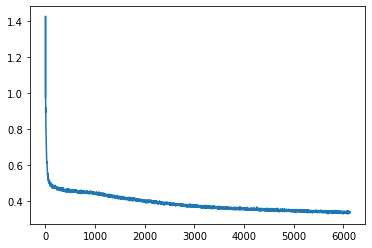

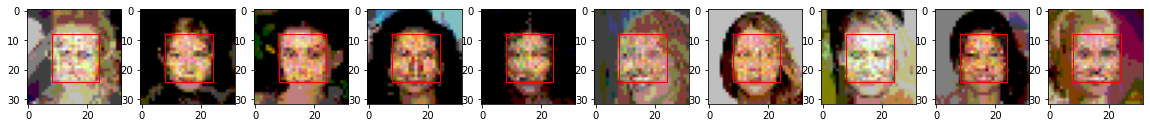

Epoch 20 Loss: 0.34


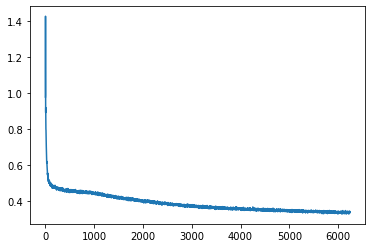

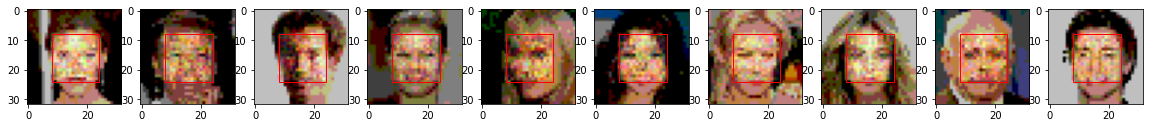

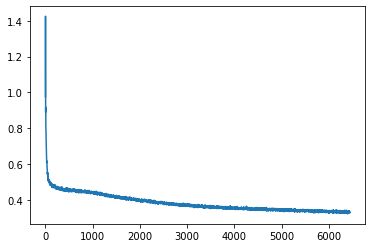

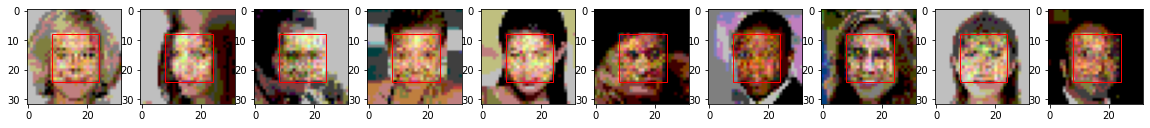

Epoch 21 Loss: 0.33


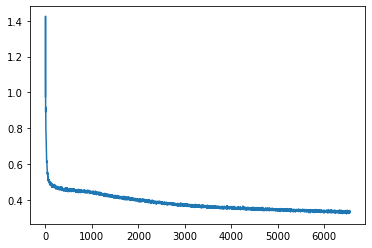

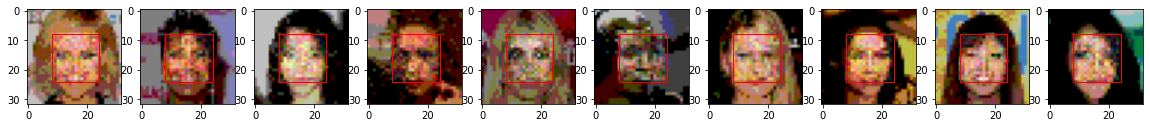

KeyboardInterrupt: ignored

In [ ]:
data_dim = (3,32,32)
batch_size = 64

class Solver(object):
    def __init__(self, learning_rate=0.0001, n_epochs=128):
        self.train_loader, self.test_loader = self.create_loaders()
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)
        self.n_bits = 2

    def build(self):
        self.flow = Glow(x_size = (batch_size, *data_dim), condition_size= (batch_size, *data_dim), K=12, L=4, learn_prior=True, LU_decompose=True).to(device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=4, factor = 0.5)

    def create_loaders(self):
        train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
        test_loader=DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last = True)
        return train_loader, test_loader
    
    def preprocess(self, x, reverse, n_bits):
        n_bins = 2 ** n_bits
        if reverse == False:
          x = x/(x.max())
          x = x * 255 # scale to 255
          if n_bits < 8:
            x = torch.floor( x/2 ** (8 - n_bits))
          x = x / n_bins  - 0.5
        else:
          x = torch.clamp(x, -0.5, 0.5)
          x = x + 0.5
          x = x * n_bins
          x = torch.clamp(x * (255 / n_bins), 0, 255).byte()
        return x

    def uniform_binning_correction(self, x, n_bits):
        b, c, h, w = x.size()
        n_bins = 2 ** n_bits
        chw = c * h * w
        x_noise = x + torch.zeros_like(x).uniform_(0, 1.0 / n_bins)
        objective = -np.log(n_bins) * chw * torch.ones(b, device=x.device)
        return x_noise, objective

    def train(self):
        self.losses = []
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1
            self.batch_loss_history = []
            for batch_i, image in enumerate(tqdm(self.train_loader, desc='Batch', leave=False)):
                condition, image = image.split(3, 1)
                image = image.to(device)
                condition = condition.to(device)

                x = self.preprocess(image, reverse=False, n_bits = self.n_bits)
                condition = self.preprocess(condition, reverse=False,  n_bits = self.n_bits)
                x, logdet = self.uniform_binning_correction(x, n_bits = self.n_bits)
                condition, logdet = self.uniform_binning_correction(condition, n_bits = self.n_bits)

                _, loss = self.flow.log_prob(x, condition, logdet=logdet)
          
                self.optimizer.zero_grad()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.flow.parameters(), 10, 2)
                torch.nn.utils.clip_grad_value_(self.flow.parameters(), 5)

                self.optimizer.step()

                if batch_i % 200 == 0:
                  self.plotter()     
                self.batch_loss_history.append(float(loss.data))
                self.losses.append(loss.data)
            epoch_loss = np.mean(self.batch_loss_history)
            self.scheduler.step(loss)
            print(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')
            train_losses.append(epoch_loss)
        return train_losses

    def plotter(self):
      plt.figure()
      plt.plot(self.losses)
      with torch.no_grad():
        self.flow.eval()
        image = next(iter(self.test_loader))
        condition, image = image.split(3, 1)
        image = image.to(device)
        condition = condition.to(device)
        condition = self.preprocess(condition, reverse = False, n_bits = self.n_bits)

        samples = self.flow.sample(z=None, condition= condition, num_samples = batch_size)
        samples  = self.preprocess(samples, reverse=True, n_bits = self.n_bits)
        condition = self.preprocess(condition, reverse=True, n_bits = self.n_bits)
        condition[:,:,8:24,8:24] = samples[:,:,8:24,8:24]
        self.flow.train()
      fig, ax = plt.subplots(1, 10 , figsize = (20,5))
      for i in range(0,10):
        if samples[i].shape[0] == 3:
          ax[i].imshow(condition[i].permute(1,2,0).detach().cpu().numpy())
          rect = patches.Rectangle((8,8),24-8,24-8,linewidth=1,edgecolor='r',facecolor='none')
          ax[i].add_patch(rect)
        else:
          ax[i].imshow(condition[i].view(-1, data_dim[-1]).detach().cpu().numpy())
          rect = patches.Rectangle((8,8),24-8,24-8,linewidth=1,edgecolor='r',facecolor='none')
          ax[i].add_patch(rect)
      plt.show()

solver = Solver(n_epochs=40, learning_rate=0.0003)
solver.build()
train = solver.train()

# Unconditional Glow - MNIST

Extracting Mnist/MNIST/raw/train-images-idx3-ubyte.gz to Mnist/MNIST/raw



Extracting Mnist/MNIST/raw/train-labels-idx1-ubyte.gz to Mnist/MNIST/raw


Extracting Mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to Mnist/MNIST/raw


Extracting Mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to Mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


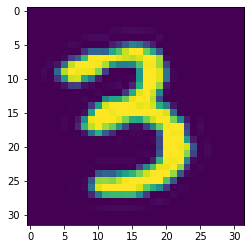

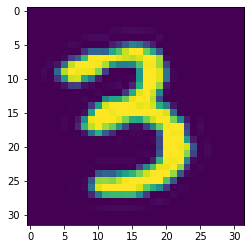

In [7]:
batch_size = 128
data_set_type = "mnist"

n_frames = 2

testset = stochasticMovingMnist.MovingMNIST(False, 'Mnist', seq_len=n_frames, image_size=32, digit_size=31, num_digits=1, 
                                            deterministic=True, three_channels=False, step_length=1, normalize=False)
trainset = stochasticMovingMnist.MovingMNIST(True, 'Mnist', seq_len=n_frames, image_size=32, digit_size=31, num_digits=1, 
                                              deterministic=True, three_channels=False, step_length=1, normalize=False)
train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader=DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)


x_plot = next(iter(train_loader))[0]
plt.imshow(x_plot[0].squeeze(0))
plt.show()
plt.imshow(x_plot[1].squeeze(0))
plt.show()

Epoch 34 Loss: 1.15


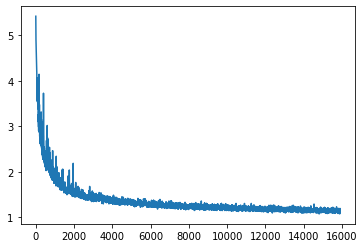

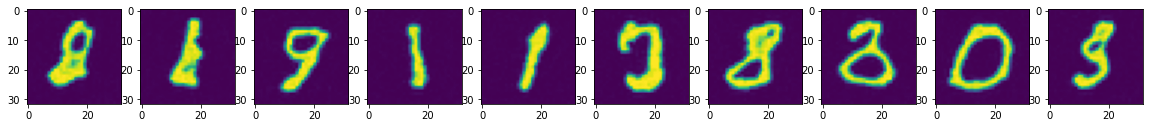

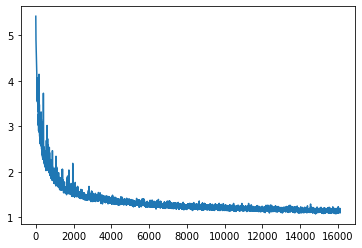

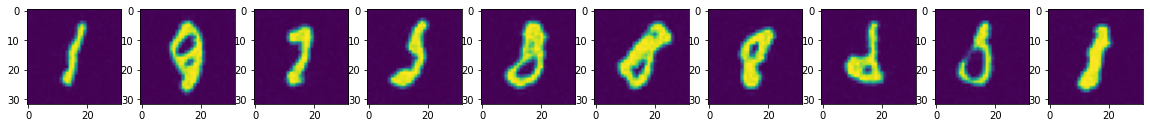

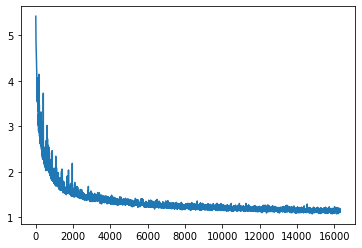

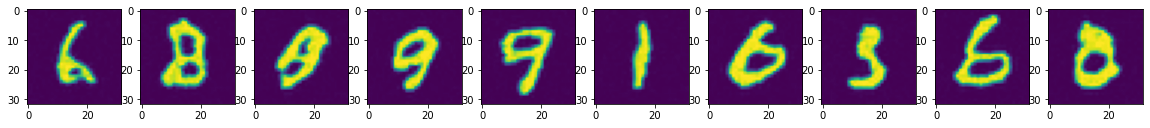

Epoch 35 Loss: 1.15


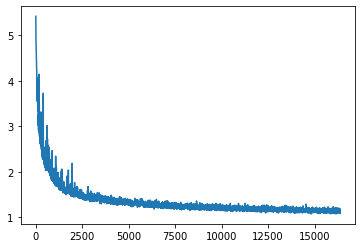

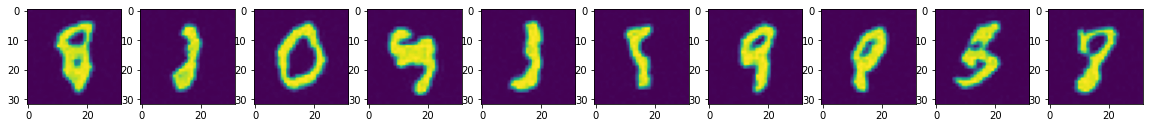

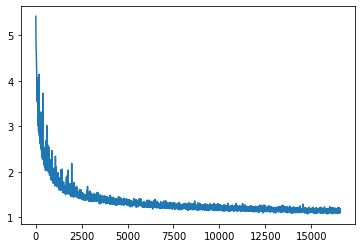

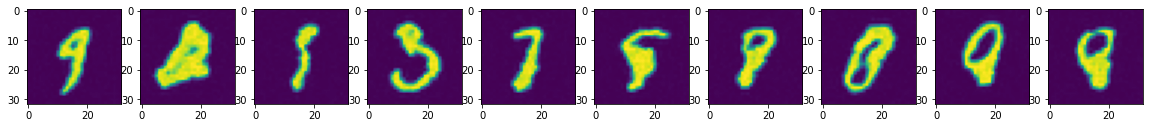

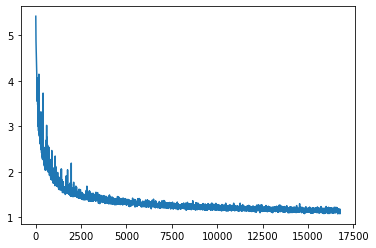

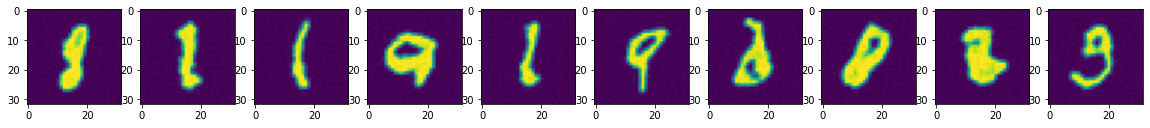

Epoch 36 Loss: 1.14


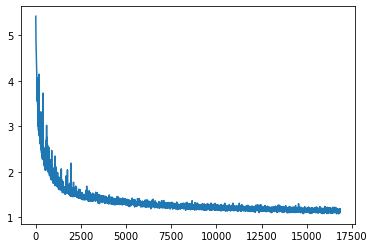

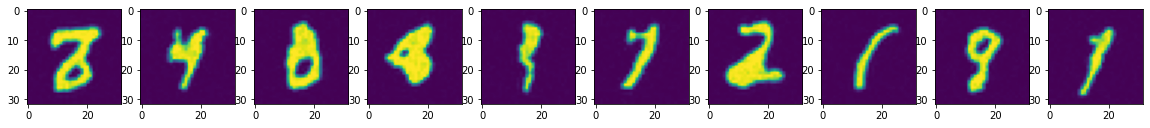

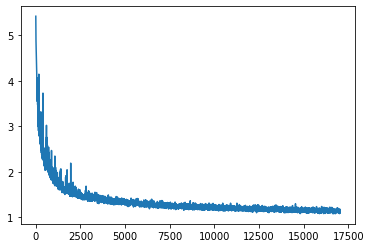

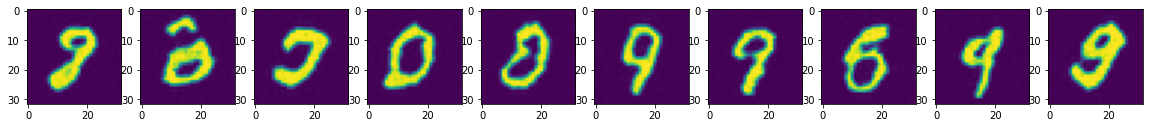

KeyboardInterrupt: ignored

In [171]:
data_dim = (1, 32, 32)

class Solver(object):
    def __init__(self, learning_rate=0.0001, n_epochs=128):
        self.train_loader, self.val_loader = self.create_loaders()
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)

    def build(self):
        self.flow = Glow(x_size = (batch_size, *data_dim), K=8, L=3, learn_prior=True, LU_decompose=True).to(device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=4, factor = 0.5)

    def create_loaders(self):
        train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
        test_loader=DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)
        return train_loader, test_loader
    
    def preprocess(self, x, reverse=False, n_bits = 6):
        n_bins = 2 ** n_bits
        if reverse == False:
          x = x * 255 # scale to 255
          if n_bits < 8:
            x = torch.floor( x/2 ** (8 - n_bits) )
          x = x / n_bins  - 0.5
        else:
          x = torch.clamp(x, -0.5, 0.5)
          x = x + 0.5
          x = x * n_bins
          x = torch.clamp(x * (255 / n_bins), 0, 255).byte()
        return x
    
    def uniform_binning_correction(self, x, n_bits=6):
        b, c, h, w = x.size()
        n_bins = 2 ** n_bits
        chw = c * h * w
        x_noise = x +  torch.zeros_like(x).uniform_(0, 1.0 / n_bins)
        objective = -np.log(n_bins) * chw * torch.ones(b, device=x.device)
        return x_noise, objective

    def train(self):
        self.losses = []
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1
            self.batch_loss_history = []
            for batch_i, image in enumerate(tqdm(self.train_loader, desc='Batch', leave=False)):
                if len(image.shape) == 5:
                  image = image[:,0,:,:,:].to(device)
                else:
                  image = image.to(device)
                logit_x = self.preprocess(image)
                logit_x, logdet=self.uniform_binning_correction(logit_x)
                
                _, loss = self.flow.log_prob(logit_x, logdet = logdet)
          
                self.optimizer.zero_grad()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.flow.parameters(), 10, 2)
                torch.nn.utils.clip_grad_value_(self.flow.parameters(), 5)

                self.optimizer.step()

                if batch_i % 200 == 0:
                  self.plotter()     
                self.batch_loss_history.append(float(loss.data))
                self.losses.append(loss.data)
            epoch_loss = np.mean(self.batch_loss_history)
            #self.scheduler.step(loss)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')
            train_losses.append(epoch_loss)
        return train_losses

    def plotter(self):
      plt.figure()
      plt.plot(self.losses)
      with torch.no_grad():
        self.flow.eval()
        samples=self.flow.sample(z=None, num_samples = 12)
        self.flow.train()
      samples  = self.preprocess(samples, reverse=True)
      fig, ax = plt.subplots(1, 10 , figsize = (20,5))
      for i in range(0,10):
        if samples[i].shape[0] == 3:
          ax[i].imshow(samples[i].permute(1,2,0).detach().cpu().numpy())
        else:
          ax[i].imshow(samples[i].view(-1, data_dim[-1]).detach().cpu().numpy())
      plt.show()

solver = Solver(n_epochs=40, learning_rate=0.0003)
solver.build()
train = solver.train()

In [172]:
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/data/mnist', train=True, download=True,
                             transform=transforms.Compose([
                                transforms.Resize(32, interpolation=1),
                               transforms.ToTensor(),
                             ])),
  batch_size=128, shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/data/mnist', train=False, download=True,
                             transform=transforms.Compose([
                                transforms.Resize(32, interpolation=1),
                               transforms.ToTensor(),
                             ])),
  batch_size=128, shuffle=True, drop_last=True)

In [173]:
from sklearn.manifold import TSNE
import seaborn as sns

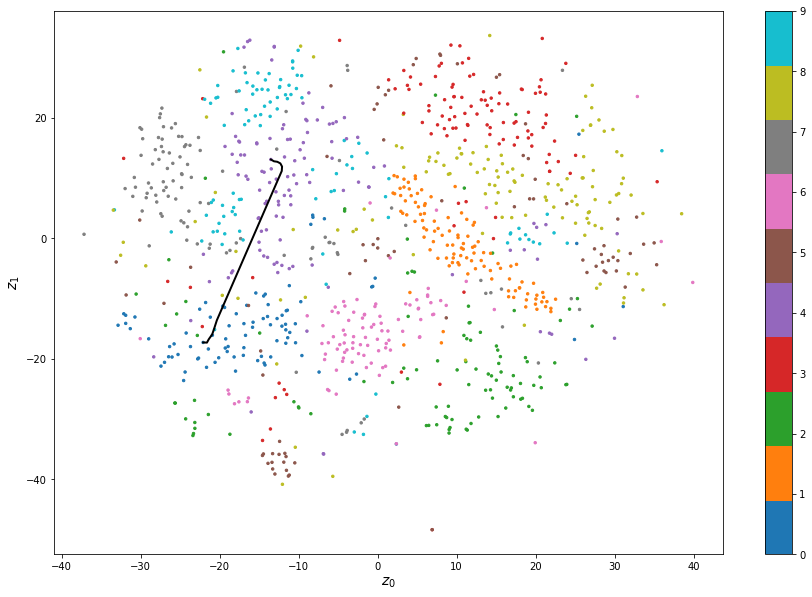

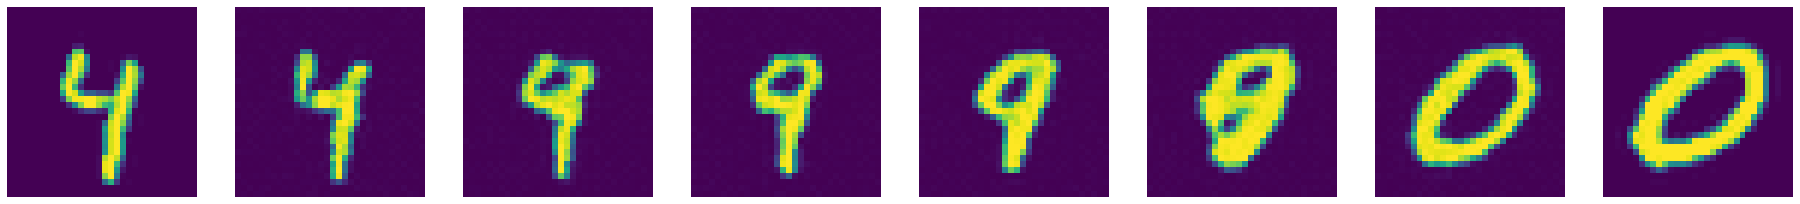

In [211]:
t_sne_inputs = []
t_sne_labels = []
L=3
undo_z = Squeeze2d()
num_steps = 12
stop = 7
plot_divisor = 2

with torch.no_grad():
  for n, image_batch in enumerate(test_loader):
    x = image_batch[0].to(device)
    labels = image_batch[1].numpy()
    x = solver.preprocess(x)
    
    z, _ = solver.flow.log_prob(x, logdet=0.0)
    z_final=z
    for i in range(L-1):
      z = undo_z(z, undo_squeeze=True)

    z = z.view((z.shape[0], -1)).detach().cpu().numpy()
    t_sne_inputs.append(z)
    t_sne_labels.append(labels)

    if n == stop:
      z_start = z_final[0]
      z_end = z_final[-1]
      z_batch_plot = [z_start]
      z_batch = []
      for i in range(num_steps):
          ratio = i / (num_steps - 1)
          z_interp = ratio * z_end + (1.0 - ratio) * z_start
          z_batch.append(z_interp)
          z_batch_plot.append(z_interp)
      z_batch_plot.append(z_end)
      z_batch = torch.stack(z_batch)

      z_batch_plot = torch.stack(z_batch_plot)

      for i in range(L-1):
        z_batch = undo_z(z_batch, undo_squeeze=True)
      z_batch = z_batch.view((z_batch.shape[0], -1)).detach().cpu().numpy()
      t_sne_inputs.append(z_batch)
      break

t_sne_inputs = np.vstack(t_sne_inputs)
t_sne_labels = np.vstack(t_sne_labels).reshape(-1)

z_reduced = TSNE(n_components=2, random_state=0, perplexity=30, early_exaggeration=12, learning_rate=200, n_iter = 1000).fit_transform(t_sne_inputs)

plt.figure(figsize = (15,10))
plt.plot(z_reduced[(128*(stop+1)):, 0], z_reduced[(128*(stop+1)):, 1], linewidth=2, color='k')
plt.scatter(z_reduced[0:(128*(stop+1)), 0], z_reduced[0:(128*(stop+1)), 1], c=t_sne_labels, s=6, cmap="tab10")
plt.colorbar()
plt.xlabel(r"$z_0$", fontsize=14)
plt.ylabel(r"$z_1$", fontsize=14)

#plot
total = num_steps//plot_divisor + 2
fig = plt.figure(figsize=(4 * total, 4))
subplots = []
for n in range(total):
    subplot = fig.add_subplot(1, total, n + 1)
    subplots.append(subplot)
rev_x_batch = solver.flow.sample(z_batch_plot, num_samples=2)
rev_x_img_list = torch.zeros((num_steps+2,1,32,32))
x_start_img = solver.preprocess(x[0], reverse=True, n_bits=n_bits)
rev_x_img_list[0,...] = x_start_img
subplots[0].imshow(x_start_img.view(-1,32).detach().cpu().numpy(), interpolation="none")
subplots[0].axis("off")
k=0
for n in range(num_steps):
    rev_x_img = solver.preprocess(rev_x_batch.data[n + 1], reverse=True, n_bits=n_bits)
    rev_x_img_list[n+1,...] =rev_x_img
    if n % plot_divisor == 0:
      k+=1
      subplots[k].imshow(rev_x_img.view(-1,32).detach().cpu().numpy(), interpolation="none")
      subplots[k].axis("off")
x_end_img =solver.preprocess(x[-1], reverse=True, n_bits=n_bits)
rev_x_img_list[n+1,...] =x_end_img
subplots[-1].imshow(x_end_img.view(-1,32).detach().cpu().numpy(), interpolation="none")
subplots[-1].axis("off")
plt.pause(.01)
#